In [36]:
import glob
import xarray as xr
import matplotlib.pyplot as plt
import h5py
import numpy as np
import datetime

In [53]:
domain_id = 7
trial_id = 33
water_year = 2023
multi_tile = 0

domains_direc = '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/ASO/selected/'
pathh = '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/'
pathh += 'domain'+str(domain_id).zfill(2)+'_trial'+str(trial_id).zfill(2)+'/'

short_name = 'VNP10A1F'
var = 'CGF_NDSI_Snow_Cover'
buffer = 5000

In [54]:
viirs_files = sorted(glob.glob(pathh+short_name+'*.h5'))
print(viirs_files[:10])
print(len(viirs_files))

dom_ref = domains_direc+'domain'+str(domain_id).zfill(2)+'_trial'+str(trial_id).zfill(2)+'.tif'
dom_ref = xr.open_dataset(dom_ref).isel(band=0).rio.reproject(4326)

lim_test = dom_ref.rio.reproject("PROJCS[\"MODIS Sinusoidal\",GEOGCS[\"GCS_unnamed ellipse\",DATUM[\"D_unknown\",SPHEROID[\"Unknown\",6371007.181,0]],PRIMEM[\"Greenwich\",0],UNIT[\"Degree\",0.0174532925199433]],PROJECTION[\"Sinusoidal\"],PARAMETER[\"false_easting\",0.0],PARAMETER[\"false_northing\",0.0],PARAMETER[\"central_meridian\",0.0],UNIT[\"Meter\",1.0]]")
# x_lims = [dom_ref.x.mean().values-buffer,dom_ref.x.mean().values+buffer]
# y_lims = [dom_ref.y.mean().values-buffer,dom_ref.y.mean().values+buffer]
x_lims = [lim_test.x.mean().values-buffer,lim_test.x.mean().values+buffer]
y_lims = [lim_test.y.mean().values-buffer,lim_test.y.mean().values+buffer]
# bounding_box = str(x_lims[0])+','+str(y_lims[0])+','+str(x_lims[1])+','+str(y_lims[1])
print(x_lims,y_lims)
# print(bounding_box)

['/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022244.h09v05.002.2023056014852.h5', '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022245.h09v05.002.2023056041525.h5', '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022246.h09v05.002.2023056062557.h5', '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022247.h09v05.002.2023056083626.h5', '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022248.h09v05.002.2023056103741.h5', '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022249.h09v05.002.2023056125951.h5', '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022250.h09v05.002.2023056145652.h5', '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07

In [55]:
def assign_and_grid(ds):
    with h5py.File(file,'r') as f:
        x = f['HDFEOS']['GRIDS']['VIIRS_Grid_IMG_2D']['XDim'][:]
        y = f['HDFEOS']['GRIDS']['VIIRS_Grid_IMG_2D']['YDim'][:]
        data = f['HDFEOS']['GRIDS']['VIIRS_Grid_IMG_2D']['Data Fields']['CGF_NDSI_Snow_Cover'][:]

    # Create coordinate arrays (adjust if you need a specific dimension order)
    coords = {'x': x, 'y': y}
    # Create the xarray dataset
    ds = xr.DataArray(data, coords=coords, dims=['y', 'x'])
    # If you need to create a full Dataset (not just a DataArray), you can do:
    ds = ds.to_dataset(name='CGF_NDSI_Snow_Cover')
    return ds

def reproject_func(ds,var,dom_ref,x_lims,y_lims):
    ds = ds[var]
    ds.rio.write_crs("PROJCS[\"MODIS Sinusoidal\",GEOGCS[\"GCS_unnamed ellipse\",DATUM[\"D_unknown\",SPHEROID[\"Unknown\",6371007.181,0]],PRIMEM[\"Greenwich\",0],UNIT[\"Degree\",0.0174532925199433]],PROJECTION[\"Sinusoidal\"],PARAMETER[\"false_easting\",0.0],PARAMETER[\"false_northing\",0.0],PARAMETER[\"central_meridian\",0.0],UNIT[\"Meter\",1.0]]", inplace=True)
#     ds = ds.rio.reproject(dom_ref.rio.crs)
#     ds.rio.reproject_match(dom_ref).plot(vmax=100)
    ds = ds.sel(x=slice(x_lims[0],x_lims[1]),y=slice(y_lims[1],y_lims[0]))
    return ds

In [56]:
date_list = []
ds_concat = []
for fCount,file in enumerate(viirs_files):
    print(file)
    
    try:
        ds = xr.open_dataset(file, engine="netcdf4")
        ds = assign_and_grid(ds)
        ds = reproject_func(ds,var,dom_ref,x_lims,y_lims)
        ds = ds.where(ds <= 100)

        if len(ds.values[~np.isnan(ds.values)]) > 0:
            print(ds.shape)
#             fg,ax = plt.subplots()
#             ds.plot(ax=ax,vmin=0,vmax=100)
#             ax.set_title(fCount)

            subsamp = file.split('/')[-1].split('.')[1]
            date_list.append(np.datetime64(datetime.date(int(subsamp[1:5]),1,1)+datetime.timedelta(days=int(subsamp[5:9])-1)))
            ds_concat.append(ds)
    except:
        print('potentially corrupted file?')
      
#     if fCount == 1:
#         break

ds_concat = xr.concat(ds_concat,dim="time")
ds_concat['time'] = ('time', date_list)

/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022244.h09v05.002.2023056014852.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022245.h09v05.002.2023056041525.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022246.h09v05.002.2023056062557.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022247.h09v05.002.2023056083626.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022248.h09v05.002.2023056103741.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022249.h09v05.002.2023056125951.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022250.h09v05.002.2023056145652.h5
(27, 27)
/Users/jpflug/Documents/Projects/s

(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022305.h09v05.002.2023069125838.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022306.h09v05.002.2023069141343.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022307.h09v05.002.2023069160944.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022308.h09v05.002.2023069174310.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022309.h09v05.002.2023069192112.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022310.h09v05.002.2023069205315.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2022311.h09v05.002.2023069223743.h5
(27, 27)
/Users/jpflug/Documents/P

(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023002.h09v05.002.2023093170555.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023003.h09v05.002.2023093191501.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023004.h09v05.002.2023093210257.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023005.h09v05.002.2023093224804.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023006.h09v05.002.2023094004142.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023007.h09v05.002.2023094023156.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023008.h09v05.002.2023094043533.h5
(27, 27)
/Users/jpflug/Documents/P

(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023062.h09v05.002.2023101031131.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023063.h09v05.002.2023101051041.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023064.h09v05.002.2023101070035.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023065.h09v05.002.2023101084032.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023066.h09v05.002.2023101100735.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023067.h09v05.002.2023101113103.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023068.h09v05.002.2023101125634.h5
(27, 27)
/Users/jpflug/Documents/P

(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023122.h09v05.002.2023131205834.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023123.h09v05.002.2023131224842.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023124.h09v05.002.2023132002501.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023125.h09v05.002.2023132024636.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023126.h09v05.002.2023132045900.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023127.h09v05.002.2023132065733.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023128.h09v05.002.2023132162630.h5
(27, 27)
/Users/jpflug/Documents/P

(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023183.h09v05.002.2023184091937.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023184.h09v05.002.2023185104013.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023185.h09v05.002.2023186101452.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023186.h09v05.002.2023187193252.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023187.h09v05.002.2023188103704.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023188.h09v05.002.2023191011859.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023189.h09v05.002.2023191072840.h5
(27, 27)
/Users/jpflug/Documents/P

(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023243.h09v05.002.2023244092915.h5
(27, 27)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/VNP10A1F.A2023244.h09v05.002.2023245092340.h5
(27, 27)


In [57]:
if multi_tile:
    # Group by unique times
    grouped = ds_concat.groupby('time')

    # Apply nanmean to each group, keeping it as an xarray.DataArray
    ds_concat = grouped.map(
        lambda group: xr.DataArray(
            np.nanmean(group, axis=0),  # Compute nanmean along the time axis
            dims=group.dims[1:],       # Keep the original spatial dimensions
            coords={dim: group.coords[dim] for dim in group.dims[1:]}  # Preserve coordinates
        )
    )

    # Check the resulting DataArray
    # print(ds_concat)

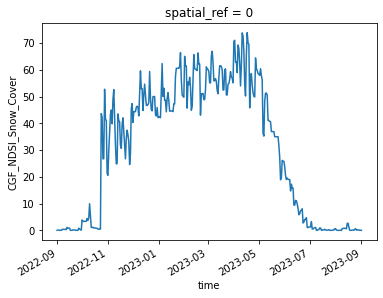

In [58]:
ds_concat.mean(dim=('x','y')).plot()

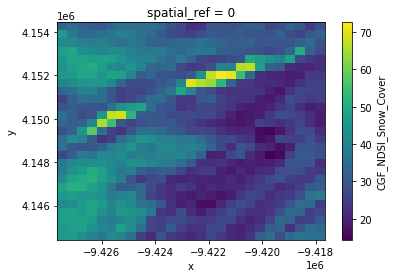

In [59]:
ds_concat.mean(dim='time').plot()

In [60]:
# for now
outfile = '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain'
outfile += str(domain_id).zfill(2)+'_trial'+str(trial_id).zfill(2)
outfile += '/processed_WY'+str(water_year)+'.nc'
print(outfile)
ds_concat.to_netcdf(outfile)

/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/VIIRS/domain07_trial33/processed_WY2023.nc
